In [1]:
import Pkg; Pkg.instantiate(); Pkg.activate()

  Activating project at `~/.julia/environments/v1.10`


In [2]:
using RxInfer
using Distributions
using Random
using GraphPlot
using Graphs
using MetaGraphsNext
using GraphPPL
using GraphViz
using Dictionaries
using Plots
using StableRNGs
using LinearAlgebra
using StatsPlots
using LaTeXStrings
using DataFrames
using CSV
using GLM
using Dates

using Cairo # necessary for draw PDF...
using Fontconfig # necessary for draw PDF...
using Compose # necessary for draw PDF...

# Coin-toss Model

In this example, we are going to perform an exact inference for a coin-toss model that can be represented as:

\begin{align}
    p(\theta) &= \text{Beta}(\theta | a, b)\\
    p(y_i | \theta) &= \text{Bernoulli}(y_i | \theta)
\end{align}

Where $y_i \in \{0, 1\}$ is a binary observation induced by Bernoulli likelihood while $\theta$ is a Beta prior distribution on the parameter of the Bernoulli Likelihood. We are interested in inferring the posterior distribution of $\theta$.

The joint probability is given by the multiplication of the likelihood and the prior, i.e.

\begin{equation}
    p(y_{1:N}, \theta) = p(\theta) \prod_{i=1}^{N} p(y_i | \theta)
\end{equation}

We can specify this model (the joint distribution) using GraphPPL's package syntax.

In [3]:
# GraphPPL.jl export `@model` macro for model specification
# It accepts a regular Julia function and builds an FFG under the hood
@model function coin_model(y, a, b)
    # We endow θ parameter of our model with some prior
    θ ~ Beta(a, b)
    # or, in this particular case, the `Uniform(0.0, 1.0)` prior also works:
    # θ ~ Uniform(0.0, 1.0)

    # We assume that outcome of each coin flip is governed by the Bernoulli distribution
    for i in eachindex(y)
        y[i] ~ Bernoulli(θ)
    end
end

In [4]:
# condition the model on some observed data
conditioned = coin_model(a = 2.0, b = 7.0) | (y = [ true, false, true ], );

In [5]:
# `Create` the actual graph of the model conditioned on the data
rxi_model = RxInfer.create_model(conditioned);

In [6]:
gppl_model = RxInfer.getmodel(rxi_model);

In [7]:
# Extract the MetaGraphsNext graph
meta_graph = gppl_model.graph;

# Linear Regression Model

In [8]:
function generate_data(a, b, v, nr_samples; rng=StableRNG(1234))
    x = float.(collect(1:nr_samples))
    y = a .* x .+ b .+ randn(rng, nr_samples) .* sqrt(v)
    return x, y
end;

In [9]:
x_data, y_data = generate_data(0.5, 25.0, 1.0, 250);

# scatter(x_data, y_data, title = "Dataset (City road)", legend=false)
# xlabel!("Speed")
# ylabel!("Fuel consumption")

In [10]:
@model function linear_regression(x, y)
    a ~ Normal(mean = 0.0, variance = 1.0)
    b ~ Normal(mean = 0.0, variance = 100.0)    
    y .~ Normal(mean = a .* x .+ b, variance = 1.0)
end

In [11]:
# Prepare the data
x_data = [1.0, 2.0, 3.0, 4.0, 5.0]  # example input data
y_data = [2.0, 4.1, 6.2, 8.3, 10.4];  # example observed data

In [12]:
linr_conditioned = linear_regression() | (x = x_data, y = y_data, );

In [13]:
# Create the RxInfer model and inject the data
linr_rxi_model = GraphPPL.create_model(linr_conditioned);

In [14]:
# Extract the GraphPPL.Model
linr_gppl_model = RxInfer.getmodel(linr_rxi_model);

In [15]:
# Extract the MetaGraphsNext meta graph
linr_meta_graph = linr_gppl_model.graph;

# Hidden Markov Model with Control

In [16]:
@model function hidden_markov_model(x)
    B ~ MatrixDirichlet(ones(3, 3))
    A ~ MatrixDirichlet([10.0 1.0 1.0; 
                         1.0 10.0 1.0; 
                         1.0 1.0 10.0 ])    
    s₀ ~ Categorical(fill(1.0/3.0, 3))
    
    sₖ₋₁ = s₀
    for k in eachindex(x)
        s[k] ~ Transition(sₖ₋₁, B)
        x[k] ~ Transition(s[k], A)
        sₖ₋₁ = s[k]
    end
end

In [17]:
hmm_conditioned = hidden_markov_model() | (x = [[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]],);

In [18]:
hmm_rxi_model = RxInfer.create_model(hmm_conditioned);

In [19]:
hmm_gppl_model = RxInfer.getmodel(hmm_rxi_model);

In [20]:
hmm_meta_graph = hmm_gppl_model.graph;

# Time-Varying Autoregressive Model

In [21]:
@model function lar_model(
    x, ##. data/observations 
    𝚃ᴬᴿ, ##. Uni/Multi variate 
    Mᴬᴿ, ##. AR order
    vᵤ, ##. unit vector 
    τ) ##. observation precision     
        ## Priors
        γ  ~ Gamma(α = 1.0, β = 1.0) ##. for transition precision    
        if 𝚃ᴬᴿ === Multivariate
            θ  ~ MvNormal(μ = zeros(Mᴬᴿ), Λ = diageye(Mᴬᴿ)) ##.kw μ,Λ only work inside macro
            s₀ ~ MvNormal(μ = zeros(Mᴬᴿ), Λ = diageye(Mᴬᴿ)) ##.kw μ,Λ only work inside macro
        else ## Univariate
            θ  ~ Normal(μ = 0.0, γ = 1.0)
            s₀ ~ Normal(μ = 0.0, γ = 1.0)
        end
        sₜ₋₁ = s₀
        for t in eachindex(x)
            s[t] ~ AR(sₜ₋₁, θ, γ) #.Eq (2b)
            if 𝚃ᴬᴿ === Multivariate
                x[t] ~ Normal(μ = dot(vᵤ, s[t]), γ = τ) #.Eq (2c)
            else
                x[t] ~ Normal(μ = vᵤ*s[t], γ = τ) #.Eq (2c)
            end
            sₜ₋₁ = s[t]
        end
    end

In [22]:
𝚃ᴬᴿ = Univariate
m = 1
τ̃ = 0.001 ## assumed observation precision
lar_conditioned = lar_model(
    𝚃ᴬᴿ=𝚃ᴬᴿ, 
    Mᴬᴿ=m, 
    vᵤ=ReactiveMP.ar_unit(𝚃ᴬᴿ, m), 
    τ=τ̃
) | (x = [266.0, 145.0, 183.0],);

In [23]:
lar_rxi_model = RxInfer.create_model(lar_conditioned);

In [24]:
lar_gppl_model = RxInfer.getmodel(lar_rxi_model);

In [25]:
lar_meta_graph = lar_gppl_model.graph;

# Chris's Model Namespace Handling

### For use with verbosity modulation:

In [26]:
function get_node_properties(model::GraphPPL.Model, vertex)
    # Set up return value
    namespace_variables = Dict{Symbol, Any}()

    # Get the properties of the node   
    label = MetaGraphsNext.label_for(model.graph, vertex)
    properties = model[label].properties

    # Add label to the dictionary
    namespace_variables[:label] = label
    
    # Get field names
    field_names = fieldnames(typeof(properties))

    # Add field names and values to the dictionary
    for field_name in field_names
        namespace_variables[field_name] = getproperty(properties, field_name)
    end

    return namespace_variables
end

get_node_properties (generic function with 1 method)

In [27]:
function get_node_properties(properties::GraphPPL.FactorNodeProperties)
    # Set up return value
    namespace_variables = Dict{Symbol, Any}()
    
    # Get field names
    field_names = fieldnames(typeof(properties))

    # Add field names and values to the dictionary
    for field_name in field_names
        namespace_variables[field_name] = getproperty(properties, field_name)
    end

    return namespace_variables
end

get_node_properties (generic function with 2 methods)

In [28]:
function get_node_properties(properties::GraphPPL.VariableNodeProperties)
    # Set up return value
    namespace_variables = Dict{Symbol, Any}()
    
    # Get field names
    field_names = fieldnames(typeof(properties))

    # Add field names and values to the dictionary
    for field_name in field_names
        namespace_variables[field_name] = getproperty(properties, field_name)
    end

    return namespace_variables
end

get_node_properties (generic function with 3 methods)

In [29]:
"""
Constructs a dict of dicts. 

The key is the unique GraphPPL.NodeLabel.global_counter value for each node.
The value is a dictionary containing the namespace for the node with ID == Key. 
"""
function get_namespace_variables_dict(model::GraphPPL.Model)
    
    node_properties_dict = Dict{Int64, Dict{Symbol, Any}}()
    
    for vertex in MetaGraphsNext.vertices(model.graph)
        
        node_properties = get_node_properties(model, vertex)
        
        global_counter_id = node_properties[:label].global_counter
        
        node_properties_dict[global_counter_id] = node_properties
    end
    
    return node_properties_dict
end

get_namespace_variables_dict

In [30]:
global_namespace_dict_coin = get_namespace_variables_dict(gppl_model)

Dict{Int64, Dict{Symbol, Any}} with 10 entries:
  5  => Dict(:index=>1, :kind=>:data, :value=>nothing, :link=>nothing, :label=>…
  4  => Dict(:label=>Beta_4, :fform=>Beta, :neighbors=>Tuple{NodeLabel, EdgeLab…
  6  => Dict(:label=>Bernoulli_6, :fform=>Bernoulli, :neighbors=>Tuple{NodeLabe…
  7  => Dict(:index=>2, :kind=>:data, :value=>nothing, :link=>nothing, :label=>…
  2  => Dict(:index=>nothing, :kind=>:constant, :value=>2.0, :link=>nothing, :l…
  10 => Dict(:label=>Bernoulli_10, :fform=>Bernoulli, :neighbors=>Tuple{NodeLab…
  9  => Dict(:index=>3, :kind=>:data, :value=>nothing, :link=>nothing, :label=>…
  8  => Dict(:label=>Bernoulli_8, :fform=>Bernoulli, :neighbors=>Tuple{NodeLabe…
  3  => Dict(:index=>nothing, :kind=>:constant, :value=>7.0, :link=>nothing, :l…
  1  => Dict(:index=>nothing, :kind=>:random, :value=>nothing, :link=>nothing, …

In [31]:
function get_sanitized_variable_node_name(var_namespace_dict)
    
    san_str_name_var = string(var_namespace_dict[:label]) # was :name
    
    if var_namespace_dict[:value] == nothing
        str_val_var = "nothing"
    else
        str_val_var = string(var_namespace_dict[:value])
    end
    
    final_str = string(san_str_name_var, ":", str_val_var)

    return final_str
end

get_sanitized_variable_node_name (generic function with 1 method)

In [32]:
function get_sanitized_factor_node_name(fac_namespace_dict)

    san_str_name_fac = string(fac_namespace_dict[:label]) # was :fform
    
    return san_str_name_fac
end

get_sanitized_factor_node_name (generic function with 1 method)

In [33]:
function get_sanitized_node_name(single_node_namespace_dict)
    if haskey(single_node_namespace_dict, :name)
        san_node_name_str = get_sanitized_variable_node_name(single_node_namespace_dict)
    elseif haskey(single_node_namespace_dict, :fform)
        san_node_name_str = get_sanitized_factor_node_name(single_node_namespace_dict)
    else
        return 0
    end
    return san_node_name_str
end

get_sanitized_node_name (generic function with 1 method)

In [35]:
for (key, val) in global_namespace_dict_coin
    san_node_name = get_sanitized_node_name(val)
    println(san_node_name)
end

y_5:nothing
Beta_4
Bernoulli_6
y_7:nothing
constvar_2:2.0
Bernoulli_10
y_9:nothing
Bernoulli_8
constvar_3:7.0
θ_1:nothing


# GraphViz DOT Code Generation and Visualisation

### General Helper Functions:

In [36]:
"""
Takes in the DOT string used with GraphViz.jl and 
strips it of the leading and trailing non-dot syntax.

returns a string containing 'pure' DOT syntax.
"""
function strip_dot_wrappers(dot_string::String)
    stripped_string = replace(dot_string, r"^dot\"\"\"\n" => "")
    stripped_string = replace(stripped_string, r"\n\"\"\"$" => "")
    
    return stripped_string
end

strip_dot_wrappers

In [37]:
"""
Takes a 'pure' DOT-syntax Julia string and writes this to
a .dot file. Intended to be used in combination with 
strip_dot_wrappers
"""
function write_to_dot_file(dot_string::String, file_path::String)
    open(file_path, "w") do file
        write(file, dot_string)
    end
end

write_to_dot_file

In [38]:
"""
Takes a source (src) .dot file and generates a .pdf
render of the encoded graph. PDF render is saved to 
the destination (dst) .pdf file. 

src_dot_file_path is assumed to be 'some_path/some_name.dot' and
dst_pdf_file_path_name is assumed to be 'some_path/some_name.pdf'. 
That is, both file extensions should be specified. 
"""
function generate_pdf_from_dot(
        src_dot_file_path::String, 
        dst_pdf_file_path_name::String
    )
    run(`dot -Tpdf $src_dot_file_path -o $dst_pdf_file_path_name`)
end

generate_pdf_from_dot

In [39]:
"""
This function encapsulates the above three functions.
"""
function dot_string_to_pdf(
        dot_string::String, 
        dst_pdf_file::String
    )
    
    pure_dot_string = strip_dot_wrappers(dot_string)
    write_to_dot_file(pure_dot_string, "tmp.dot")
    generate_pdf_from_dot("tmp.dot", dst_pdf_file)
    rm("tmp.dot")
end

dot_string_to_pdf

In [40]:
# NOT part of the GraphViz visualization functionality per-se.
# This is just a helper function for development purposes. 
function meta_graph_to_pdf(
        file_name::String,
        meta_graph::MetaGraph
    )

    layout=(args...)->spring_layout(args...; C=2)

    draw(
        PDF(
            "$file_name", 30cm, 30cm
        ), GraphPlot.gplot(
            meta_graph,
            layout=layout,
            nodelabel=collect(labels(meta_graph)),
            nodelabelsize=0.5,
            NODESIZE=0.05, # diameter of the nodes,
            nodelabelc="green",
            nodelabeldist=2.0,
            nodefillc="blue",
            edgestrokec="red",
            EDGELINEWIDTH = 0.8
        )
    )
end

meta_graph_to_pdf (generic function with 1 method)

### generate_dot Methods:

In [41]:
# This may be unesseary
abstract type TraversalStrategy end
struct SimpleIteration <: TraversalStrategy end
struct BFSTraversal <: TraversalStrategy end

In [42]:
function add_nodes!(
        io_buffer::IOBuffer, 
        Model::GraphPPL.Model, 
        global_namespace_dict::Dict{Int64, Dict{Symbol, Any}},
        ::SimpleIteration
    )
    
    for vertex in MetaGraphsNext.vertices(Model.graph)
        
        # index the label of model_namespace_variables with "vertex"
        san_label = get_sanitized_node_name(global_namespace_dict[vertex])
        
        label = MetaGraphsNext.label_for(Model.graph, vertex)
        
        properties = Model[label].properties
        
        if isa(properties, GraphPPL.FactorNodeProperties)
            write(io_buffer, "    \"$(san_label)\" [shape=square, style=filled, fillcolor=lightgray];\n")
        elseif isa(properties, GraphPPL.VariableNodeProperties)
            write(io_buffer, "    \"$(san_label)\" [shape=circle];\n")
        else
            error("Unknown node type for label $(san_label)")
        end
    end
end

add_nodes! (generic function with 1 method)

In [43]:
function add_nodes!(
        io_buffer::IOBuffer, 
        Model::GraphPPL.Model, 
        global_namespace_dict::Dict{Int64, Dict{Symbol, Any}}, 
        ::BFSTraversal
    )
    
    n = nv(Model) # number of nodes
    visited = falses(n) # array of visited nodes
    cur_level = Vector{Int}() # current level of nodes processed in BFS
    next_level = Vector{Int}() # next level of nodes for BFS
    
    s = 1 # always start at the initially created node
    if !visited[s]
        visited[s] = true
        push!(cur_level, s)
    end
    
    while !isempty(cur_level)
        for v in cur_level
            
            san_label = get_sanitized_node_name(global_namespace_dict[v])
            
            label = MetaGraphsNext.label_for(Model.graph, v)
            properties = Model[label].properties
            
            if isa(properties, GraphPPL.FactorNodeProperties)
                write(io_buffer, "    \"$(san_label)\" [shape=square, style=filled, fillcolor=lightgray];\n")
            elseif isa(properties, GraphPPL.VariableNodeProperties)
                write(io_buffer, "    \"$(san_label)\" [shape=circle];\n")
            else
                error("Unknown node type for label $(san_label)")
            end
            
            for v_neighb in MetaGraphsNext.neighbors(Model.graph, v)
                if !visited[v_neighb]
                    visited[v_neighb] = true
                    push!(next_level, v_neighb)
                end
            end
        end
        empty!(cur_level)
        cur_level, next_level = next_level, cur_level
        sort!(cur_level)
    end
end

add_nodes! (generic function with 2 methods)

In [44]:
function add_edges!(
        io_buffer::IOBuffer, 
        Model::GraphPPL.Model, 
        global_namespace_dict::Dict{Int64, Dict{Symbol, Any}},
        ::SimpleIteration, 
        edge_length::Float64
    )
    
    for edge in MetaGraphsNext.edges(Model.graph)
        source_vertex = MetaGraphsNext.label_for(Model.graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(Model.graph, edge.dst)
        
        source_san_name = get_sanitized_node_name(global_namespace_dict[source_vertex.global_counter]) # ADDED
        dest_san_name = get_sanitized_node_name(global_namespace_dict[dest_vertex.global_counter]) # ADDED
        
#         write(io_buffer, "    \"$(source_vertex)\" -- \"$(dest_vertex)\" [len=$(edge_length)];\n") # OG VERSION
        write(io_buffer, "    \"$(source_san_name)\" -- \"$(dest_san_name)\" [len=$(edge_length)];\n")
    end
end

add_edges! (generic function with 1 method)

In [45]:
function add_edges!(
        io_buffer::IOBuffer, 
        Model::GraphPPL.Model, 
        global_namespace_dict::Dict{Int64, Dict{Symbol, Any}},
        ::BFSTraversal, 
        edge_length::Float64
    )
    
    edge_set = Set{Tuple{Int, Int}}()
    
    n = nv(Model)
    visited = falses(n)
    cur_level = Vector{Int}()
    next_level = Vector{Int}()
    
    s = 1
    if !visited[s]
        visited[s] = true
        push!(cur_level, s)
    end
    
    while !isempty(cur_level)
        for v in cur_level
            for v_neighb in MetaGraphsNext.neighbors(Model.graph, v)
                edge = (min(v, v_neighb), max(v, v_neighb))
                if !(edge in edge_set)
                    source_vertex = MetaGraphsNext.label_for(Model.graph, v)
                    dest_vertex = MetaGraphsNext.label_for(Model.graph, v_neighb)
                    
                    source_san_name = get_sanitized_node_name(
                        global_namespace_dict[source_vertex.global_counter]
                    )

                    dest_san_name = get_sanitized_node_name(
                        global_namespace_dict[dest_vertex.global_counter]
                    )
                    
                    write(io_buffer, "    \"$(source_san_name)\" -- \"$(dest_san_name)\" [len=$(edge_length)];\n")
                    push!(edge_set, edge)
                end
                
                if !visited[v_neighb]
                    visited[v_neighb] = true
                    push!(next_level, v_neighb)
                end
            end
        end
        empty!(cur_level)
        cur_level, next_level = next_level, cur_level
        sort!(cur_level)
    end
end

add_edges! (generic function with 2 methods)

In [46]:
function generate_dot(;
        Model::GraphPPL.Model, 
        strategy::TraversalStrategy,
        font_size::Int, 
        edge_length::Float64 = 1.0, 
        layout::String = "neato", 
        width::Float64 = 10.0, 
        height::Float64 = 10.0
    )
    
    # get the entire namespace dict
    global_namespace_dict = get_namespace_variables_dict(Model)
    
    # use Base.IOBuffer instead of string concatenation
    io_buffer = IOBuffer()
    
    write(io_buffer, "dot\"\"\"\ngraph G {\n")
    write(io_buffer, "    layout=$(layout);\n")
    write(io_buffer, "    size=\"$(width),$(height)!\";\n")
    write(io_buffer, "    node [shape=circle, fontsize=$(font_size)];\n")
    
    # Nodes
    add_nodes!(io_buffer, Model, global_namespace_dict, strategy)
    
    # Edges
    add_edges!(io_buffer, Model, global_namespace_dict, strategy, edge_length)
    
    write(io_buffer, "}\n\"\"\"")
    
    final_dot = String(take!(io_buffer))
    
    return final_dot
end

generate_dot (generic function with 1 method)

In [47]:
"""
Takes the DOT string given by generate_dot and 
executes it to produce a GraphViz visualisation. 
"""
function show_gv(dot_code_graph::String)
    eval(Meta.parse(dot_code_graph))
end

show_gv

# Example 1 - Coin Toss Model:

### Coin Toss Model - Existing Functionality:

In [48]:
Graphs.is_cyclic(meta_graph)

false

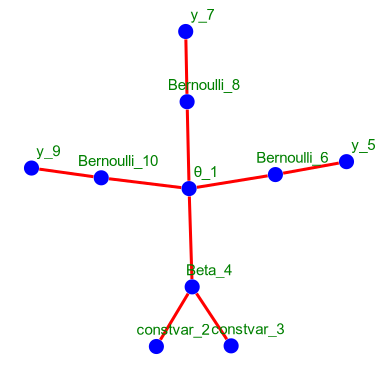

In [49]:
# The existing plotting functionality:
GraphPlot.gplot(
    meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(meta_graph)),
    nodelabelsize=1.0,
    NODESIZE=0.05, # diameter of the nodes,
    nodelabelc="green",
    nodelabeldist=3.0,
    nodefillc="blue",
    edgestrokec="red",
    EDGELINEWIDTH = 0.8
)

In [49]:
# render the meta_graph and save render to a pdf:
meta_graph_to_pdf("coin_toss_viz/coin_toss_GraphPlot.pdf", meta_graph)

### Coin Toss Model - generate_dot(SimpleIteration):

In [50]:
# create the DOT code string
coin_toss_dot_simple = generate_dot(
    Model = gppl_model, 
    strategy = SimpleIteration(),
    font_size = 7,
    edge_length = 1.0,
    layout = "neato",
    width = 6.0,
    height = 6.0
);

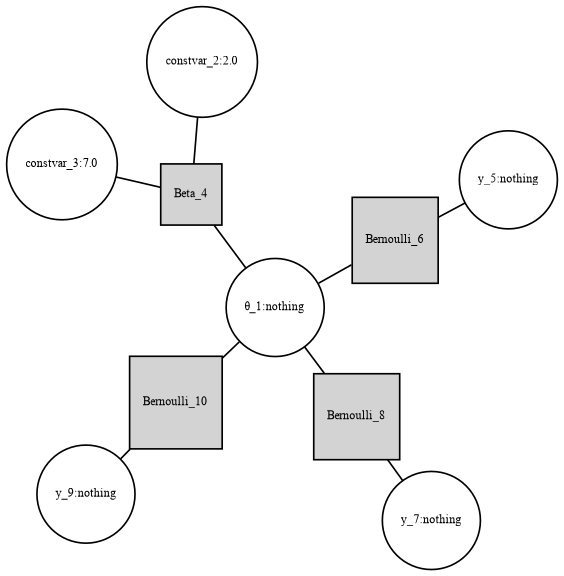

In [51]:
# execute the DOT code string
show_gv(coin_toss_dot_simple)

In [52]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(coin_toss_dot_simple, "coin_toss_viz/coin_toss_pdf_render_SimpleIter.pdf")

### Coin Toss Model - generate_dot(BFSTraversal):

In [52]:
# create the DOT code string
coin_toss_dot_BFS = generate_dot(
    Model = gppl_model, 
    strategy = BFSTraversal(),
    font_size = 7,
    edge_length = 1.0,
    layout = "neato",
    width = 6.0,
    height = 6.0
);

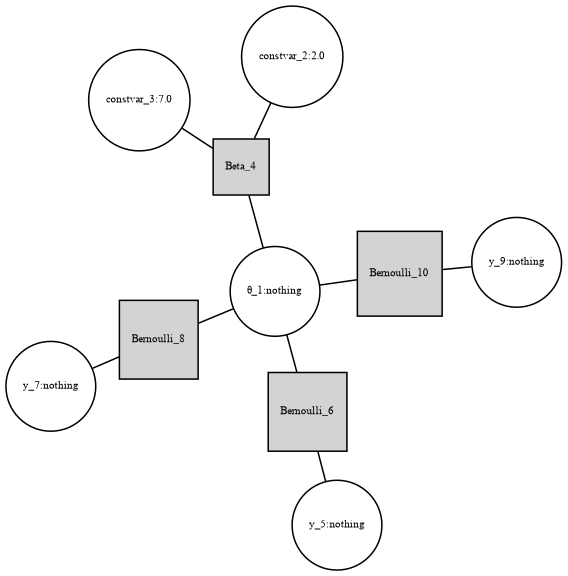

In [53]:
# execute the DOT code string
show_gv(coin_toss_dot_BFS)

In [55]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(coin_toss_dot_BFS, "coin_toss_viz/coin_toss_pdf_render_BFSTraversal.pdf")

# Example 2 - Linear Regression Model:

### Linear Regression Model - Existing Functionality:

In [56]:
Graphs.is_cyclic(linr_meta_graph)

true

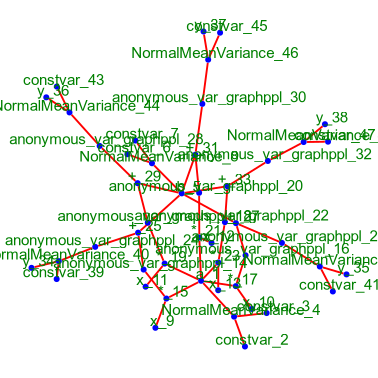

In [57]:
# The existing plotting functionality:
GraphPlot.gplot(
    linr_meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(linr_meta_graph)),
    nodelabelsize=0.1,
    NODESIZE=0.02, # diameter of the nodes,
    nodelabelc="green",
    nodelabeldist=3.0,
    nodefillc="blue",
    edgestrokec="red",
    EDGELINEWIDTH = 0.5
)

In [58]:
# render the meta_graph and save render to a pdf:
meta_graph_to_pdf("linr_reg_viz/linr_reg_GraphPlot.pdf", linr_meta_graph)

### Linear Regression Model - generate_dot(SimpleIteration):

In [59]:
# create the DOT code string
linr_model_dot_simple = generate_dot(
    Model = linr_gppl_model,
    strategy = SimpleIteration(),
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

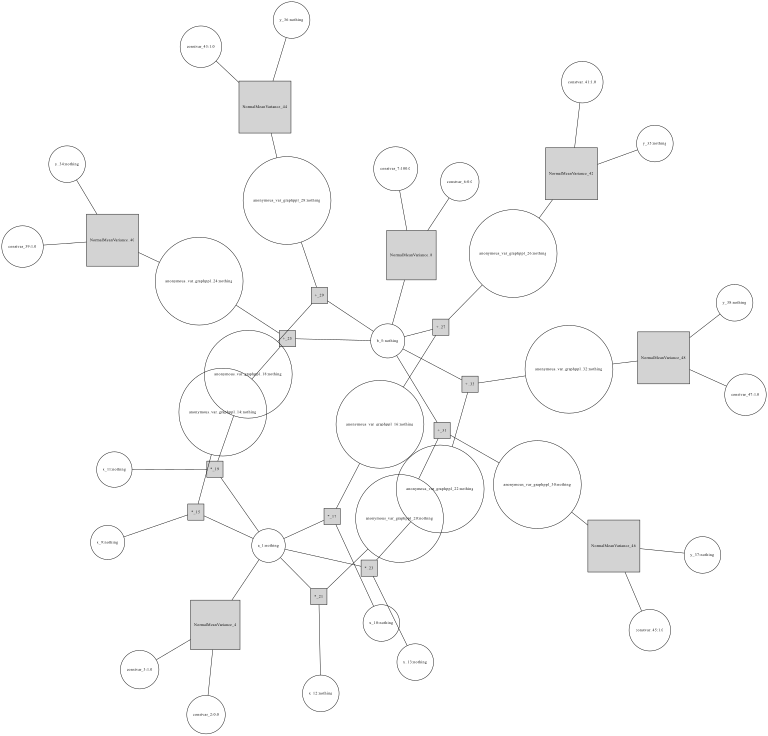

In [60]:
# execute the DOT code string
show_gv(linr_model_dot_simple)

In [61]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(linr_model_dot_simple, "linr_reg_viz/linr_model_pdf_render_SimpleIter.pdf")

### Linear Regression Model - generate_dot(BFSTraversal):

In [62]:
linr_model_dot_BFS = generate_dot(
    Model = linr_gppl_model,
    strategy = BFSTraversal(),
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

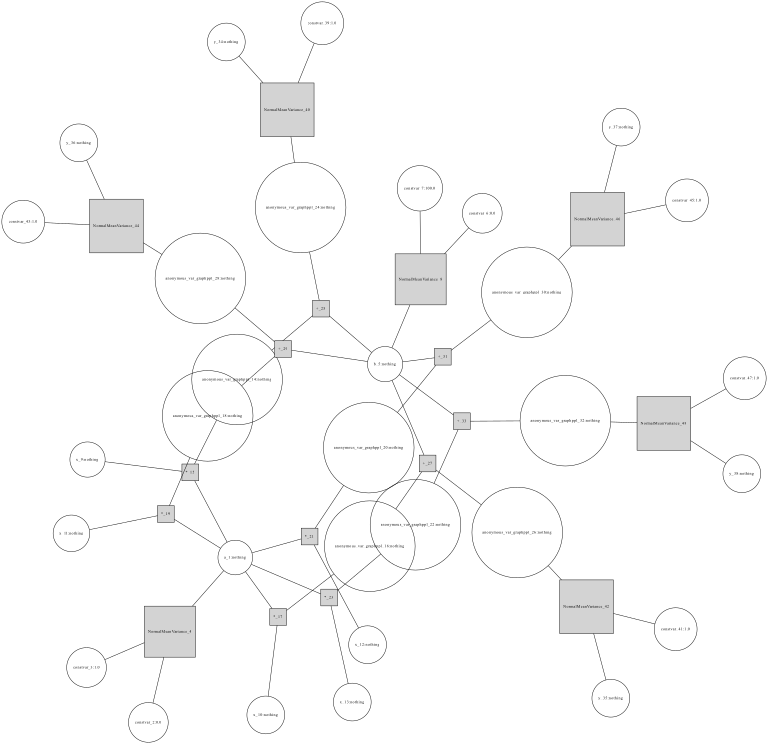

In [63]:
# execute the DOT code string
show_gv(linr_model_dot_BFS)

In [64]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(linr_model_dot_BFS, "linr_reg_viz/linr_model_BFS_pdf_render_BFSTraversal.pdf")

# Example 3 - Hidden Markov Model with Control:

### Hidden Markov Model with Control - Existing Functionality:

In [65]:
Graphs.is_cyclic(hmm_meta_graph)

true

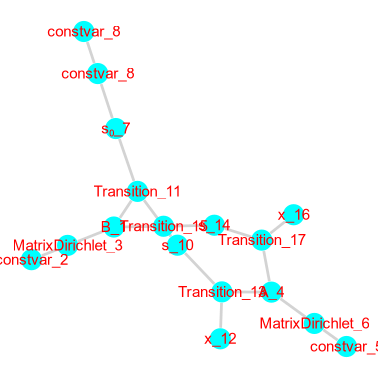


(process:15519): Pango-WARNING **: 18:06:10.918: pango_layout_set_markup_with_accel: Error on line 1 char 41: “:Real_9<” is not a valid name: “<”


In [66]:
GraphPlot.gplot( ## existing plotting functionality
    hmm_meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(hmm_meta_graph)),
    nodelabelsize=1.0,
    NODESIZE=0.07, ## diameter of the nodes
    nodelabelc="red", #.
    nodelabeldist=0.0,
    nodefillc="cyan",
)

In [70]:
# render the meta_graph and save render to a pdf:
meta_graph_to_pdf("hmm_viz/hmm_model_GraphPlot.pdf", hmm_meta_graph)


(process:15519): Pango-WARNING **: 18:06:40.615: pango_layout_set_markup_with_accel: Error on line 1 char 41: “:Real_9<” is not a valid name: “<”


### Hidden Markov Model with Control - generate_dot(SimpleIteration):

In [71]:
# create the DOT code string
hmm_model_dot_simple = generate_dot(
    Model = hmm_gppl_model,
    strategy = SimpleIteration(),
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

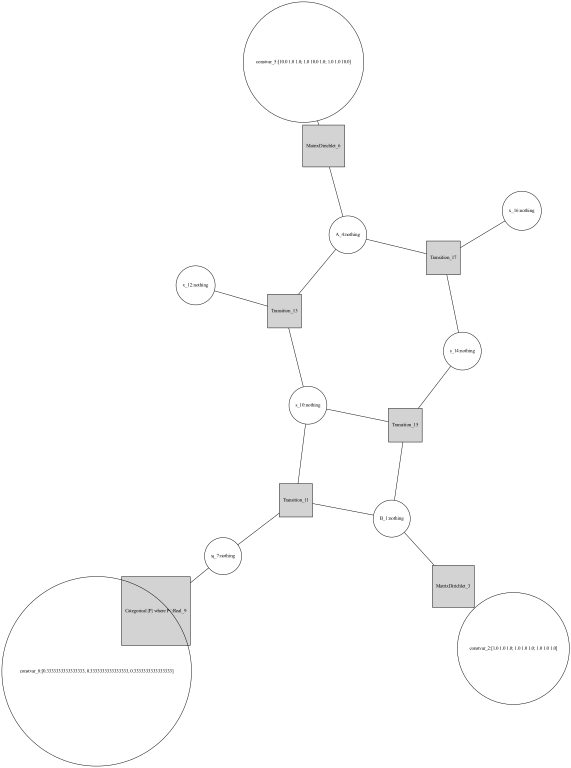

In [72]:
# execute the DOT code string
show_gv(hmm_model_dot_simple)

In [73]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(hmm_model_dot_simple, "hmm_viz/hmm_model_pdf_render_SimpleIter.pdf")

### Hidden Markov Model with Control - generate_dot(BFSTraversal):

In [74]:
# create the DOT code string
hmm_model_dot_BFS = generate_dot(
    Model = hmm_gppl_model,
    strategy = BFSTraversal(),
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

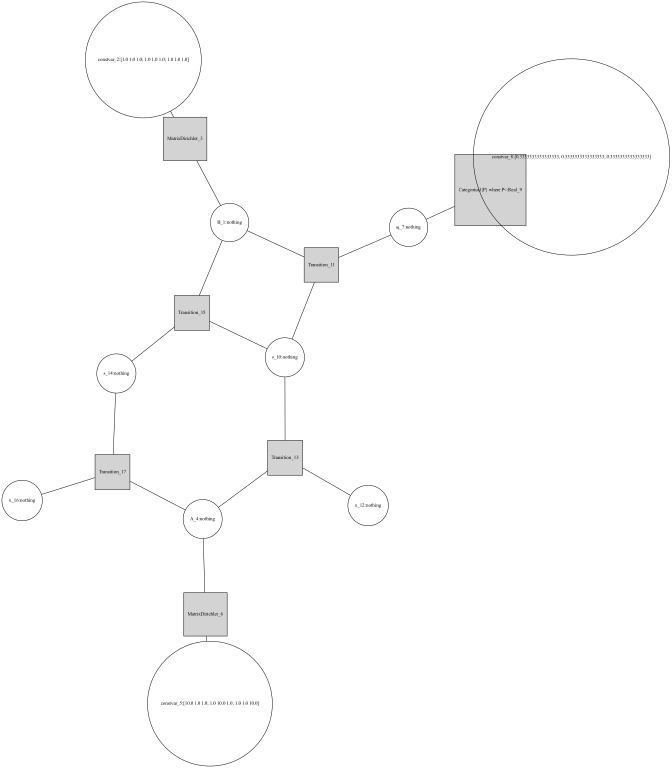

In [75]:
# execute the DOT code string
show_gv(hmm_model_dot_BFS)

In [76]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(hmm_model_dot_BFS, "hmm_viz/hmm_model_BFS_pdf_render_BFSTraversal.pdf")

# Example 4 - Time-Varying Autoregressive Model:

### Autoregressive Model - Existing Functionality:

In [78]:
Graphs.is_cyclic(lar_meta_graph)

true

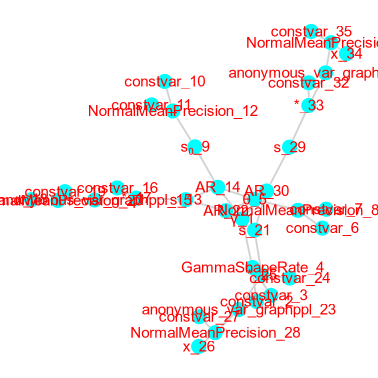

In [79]:
GraphPlot.gplot(
    lar_meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(lar_meta_graph)),
    nodelabelsize=1.0,
    NODESIZE=0.05, ## diameter of the nodes
    nodelabelc="red", #.
    nodelabeldist=0.0,
    nodefillc="cyan",
)

In [80]:
# render the meta_graph and save render to a pdf:
meta_graph_to_pdf("lar_viz/lar_model_GraphPlot.pdf", lar_meta_graph)

### Autoregressive Model - generate_dot(SimpleIteration):

In [81]:
# create the DOT code string
lar_model_dot_simple = generate_dot(
    Model = lar_gppl_model,
    strategy = SimpleIteration(),
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

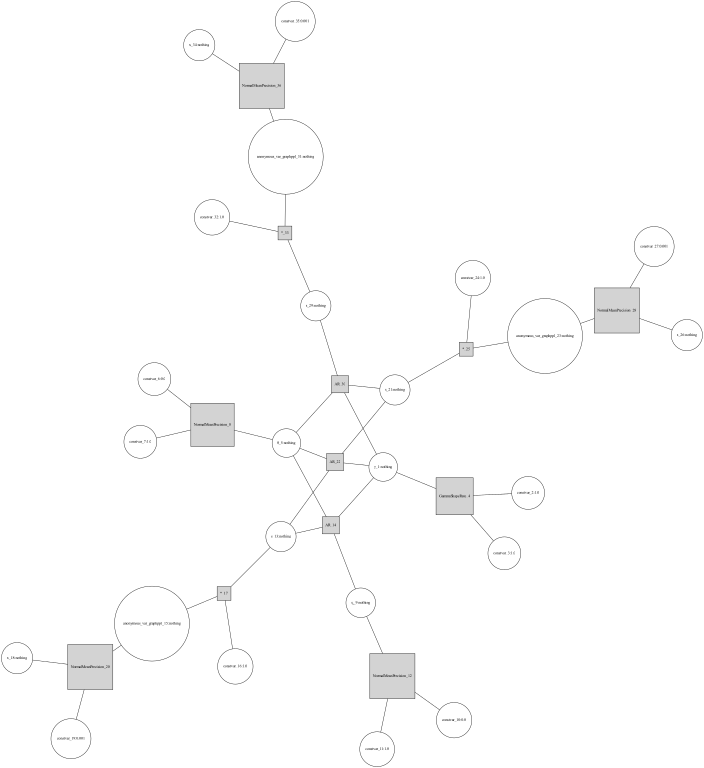

In [80]:
# execute the DOT code string
show_gv(lar_model_dot_simple)

In [82]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(lar_model_dot_simple, "lar_viz/lar_model_pdf_render_SimpleIter.pdf")

### Autoregressive Model - generate_dot(BFSTraversal):

In [83]:
# create the DOT code string
lar_model_dot_BFS = generate_dot(
    Model = lar_gppl_model,
    strategy = BFSTraversal(),
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

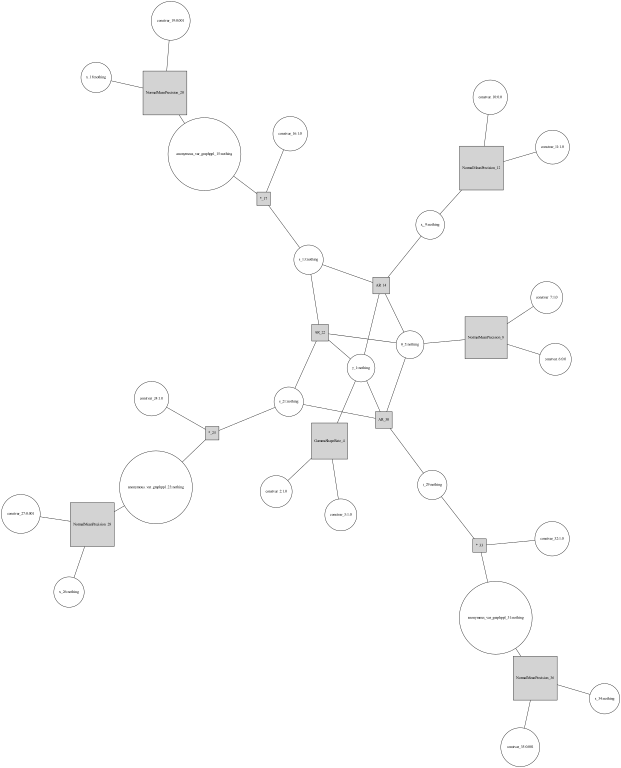

In [84]:
# execute the DOT code string
show_gv(lar_model_dot_BFS)

In [85]:
# render the DOT string and save render to a pdf:
dot_string_to_pdf(lar_model_dot_BFS, "lar_viz/lar_model_BFS_pdf_render_BFSTraversal.pdf")

# Old Code:

In [172]:
# # String(coin_model_namespace_variables[1][:name])
# function get_sanitized_variable_node_name(var_namespace_dict)
    
#     san_str_name_var = String(var_namespace_dict[:name])
    
#     # value and name if value not nothing
#     # name otherwise. 
    
#     return san_str_name_var
# end

# # String(coin_model_namespace_variables[1][:name])
# function get_sanitized_variable_node_name(var_namespace_dict)
    
#     san_str_name_var = String(var_namespace_dict[:name])
    
#     if var_namespace_dict[:value] == nothing
#         str_val_var = "nothing"
#     else
#         str_val_var = String(var_namespace_dict[:value])
#     end
    
#     # value and name if value not nothing
#     # name otherwise. 
    
#     return san_str_name_var, str_val_var
# end

# String(coin_model_namespace_variables[1][:name])

In [ ]:
# """
# Presently constructs a Vector{Dict{Symbol, Any}} of dicts.
# Each dict contains the entire namespace for exactly one node in the GraphPPL.Model. 

# It may be better to instead create a dict of dicts: Dict{Int64, Dict{Symbol, Any}} where
# each key is the global_counter for the GraphPPL.NodeLabel in question. This would make it very easy to 
# index into the entire namespace dict when iterating over the graph inside the generate_dot functionality. 
# """
# function get_namespace_variables(model::GraphPPL.Model)
    
#     node_properties_list = Vector{Dict{Symbol, Any}}() # Dict{Int64, Dict{Symbol, Any}}()
    
#     for vertex in MetaGraphsNext.vertices(model.graph)
#         node_properties = get_node_properties(model, vertex)
        
#         node_properties[:global_counter] = node_properties[:label].global_counter # ADDED ###################
        
#         push!(node_properties_list, node_properties)
#     end
    
#     return node_properties_list
# end

In [86]:
# # OG VERSION
# function add_nodes!(
#         io_buffer::IOBuffer, 
#         Model::GraphPPL.Model, 
#         ::SimpleIteration
#     )
    
#     for vertex in MetaGraphsNext.vertices(Model.graph)
#         label = MetaGraphsNext.label_for(Model.graph, vertex)
#         properties = Model[label].properties
        
#         if isa(properties, GraphPPL.FactorNodeProperties)
#             write(io_buffer, "    \"$(label)\" [shape=square, style=filled, fillcolor=lightgray];\n")
#         elseif isa(properties, GraphPPL.VariableNodeProperties)
#             write(io_buffer, "    \"$(label)\" [shape=circle];\n")
#         else
#             # should raise an error here instead
#             println("ERROR: Unknown node type for label $(label)")
#         end
#     end
# end

In [87]:
# # OG VERSION:
# function add_nodes!(
#         io_buffer::IOBuffer, 
#         Model::GraphPPL.Model, 
#         ::BFSTraversal
#     )
    
#     n = nv(Model) # number of nodes
#     visited = falses(n) # array of visited nodes
#     cur_level = Vector{Int}() # current level of nodes processed in BFS
#     next_level = Vector{Int}() # next level of nodes for BFS
    
#     s = 1 # always start at the initially created node
#     if !visited[s]
#         visited[s] = true
#         push!(cur_level, s)
#     end
    
#     while !isempty(cur_level)
#         for v in cur_level
#             label = MetaGraphsNext.label_for(Model.graph, v)
#             properties = Model[label].properties
            
#             if isa(properties, GraphPPL.FactorNodeProperties)
#                 write(io_buffer, "    \"$(label)\" [shape=square, style=filled, fillcolor=lightgray];\n")
#             elseif isa(properties, GraphPPL.VariableNodeProperties)
#                 write(io_buffer, "    \"$(label)\" [shape=circle];\n")
#             else
#                 # should raise an error here instead
#                 println("ERROR: Unknown node type for label $(label)")
#             end
            
#             for v_neighb in MetaGraphsNext.neighbors(Model.graph, v)
#                 if !visited[v_neighb]
#                     visited[v_neighb] = true
#                     push!(next_level, v_neighb)
#                 end
#             end
#         end
#         empty!(cur_level)
#         cur_level, next_level = next_level, cur_level
#         sort!(cur_level)
#     end
# end